<a href="https://colab.research.google.com/github/OVP2023/NN/blob/main/DZ3_%D0%A3%D0%BB%D1%83%D1%87%D1%88%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''Домашнее задание к занятию «Улучшение качества обучения нейросети»

Цель задания: научиться использовать в коде различные методы Transfer Learning.

Задание:
На примере датасета персонажей мультфильма Симпсонов:

    Модифицируйте код обучения, используя различные типы LR Schedulers из Pytorch. Проведите минимум 2 эксперимента с разными шедулерами.
    Подберите аугментации train данных, при которых итоговое качество на валидации станет сильно хуже, чем полученное на занятии.
    Возьмите любую архитектуру (VGG, EfficientNet или MobileNet) и примените к ней методы, которые разбирались на занятии.
    Оформите вывод по результатам проведённых экспериментов.
'''

In [1]:
import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

In [10]:
# разделим картинки на train и val в отношении 70 на 30 для каждого класса
data_dir = "/content/drive/MyDrive/simpsons_dataset"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths,
    test_size=0.3,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}"
)

Изображений в train: 2186
Изображений в val: 938


In [11]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

In [12]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))

Количество классов в train:  6
Количество классов в val:  6
Количество классов одинаково:  True


In [19]:
#Посмотрим на изображения из val и train
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(18, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=5)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

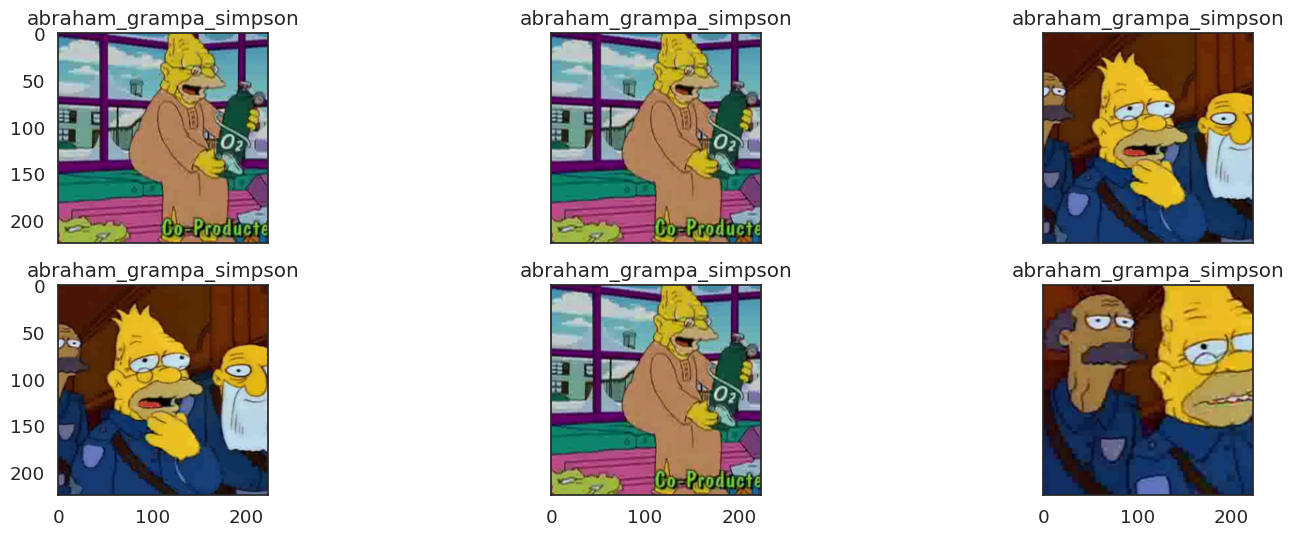

In [20]:
show_images(val_dataset)

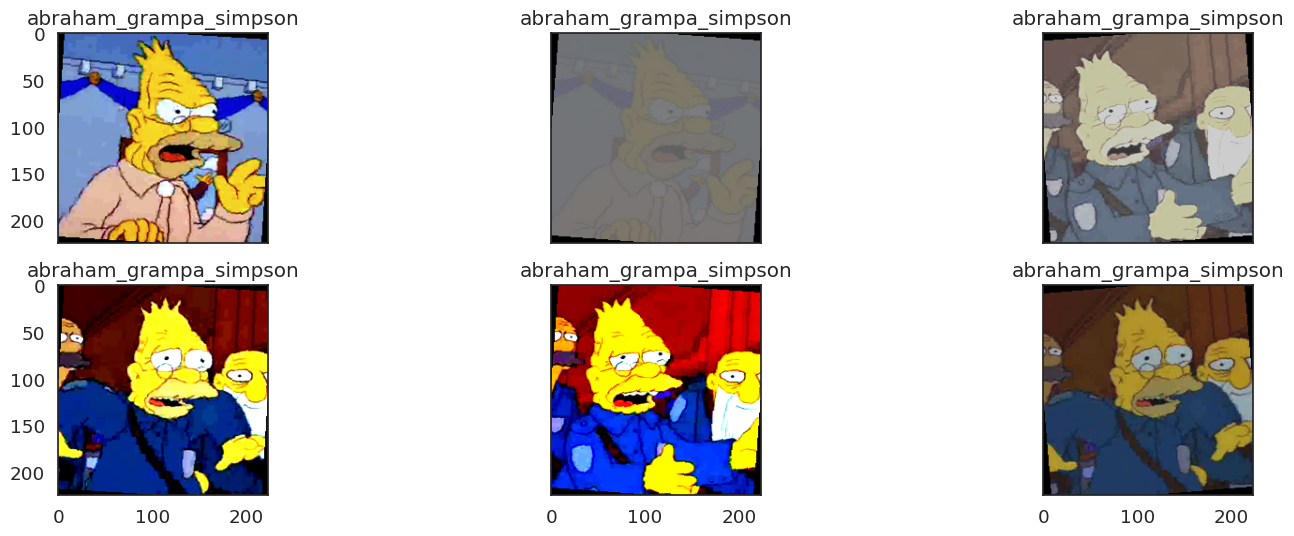

In [21]:
show_images(train_dataset)